In [1]:
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize

#file_store
import os

#time
import time
from datetime import datetime, timedelta


from ctypes import *
%matplotlib inline

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,0.4.204



In [3]:
dc = DC()
dc.idn()

Connection exist: HEWLETT-PACKARD,33120A,0,7.0-5.0-1.0



In [4]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



# Set all devises to defoult values

In [5]:
# Anapico 
anapico.off(1)

#dc 
dc.set_volt(0)

In [6]:
anapico.on(1)

In [7]:
# boundaries

freq_pump_max = 11.5 #GHz
freq_pump_min = 11 #GHz

power_pump_max = -6 #dBm
power_pump_min = -29 #dBm

dc_max = 2.8 # V
dc_min = 1 # V

# Just scan over all range

In [12]:
number_of_freq_steps = 2
number_of_power_steps = 2
number_of_dc_steps = 2 

freq = np.linspace(freq_pump_min, freq_pump_max, number_of_freq_steps)
powers = np.linspace(power_pump_min, power_pump_max, number_of_power_steps)
dcs = np.linspace(dc_min, dc_max, number_of_dc_steps)

reference_freq = 5.8

Sweep time: 0.08783333333333333 m


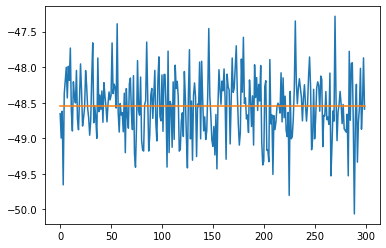

In [10]:
vna.set_cw_freq(reference_freq)
vna.set_power(0)
vna.set_nop(300)
vna.set_band(10000)
one_round_time = vna.ask_sweep_time()/60
# anapico.on(1)

anapico.off(1)
dc.set_volt(0)

print('Sweep time: {} m'.format(one_round_time))

mag, pha = vna.get_data()
reference_mag_level = np.mean(mag)
plt.plot(mag)
plt.plot(np.ones(len(mag))*reference_mag_level)

# Just sweep

In [30]:
number_of_freq_steps = 2
number_of_power_steps = 60
number_of_dc_steps = 60

freq = np.linspace(freq_pump_min, freq_pump_max, number_of_freq_steps)
powers = np.linspace(power_pump_min, power_pump_max, number_of_power_steps)
dcs = np.linspace(dc_min, dc_max, number_of_dc_steps)

reference_freq = 5.8

anapico.set_freq(1, 11.252e9)
gain = np.empty((len(powers), len(dcs)))
start_time = datetime.now()
print('Start time', start_time)


one_round_time = (vna.ask_sweep_time()+10)/60/60
print('Sweep time: {} h'.format((one_round_time)*len(powers)*len(dcs)))

Start time 2023-12-04 18:49:23.135924
Sweep time: 15.27 h


In [31]:
for i in range(len(powers)):
    for j in range(len(dcs)): 
        print(i, powers[i], j, dcs[j], end='\r')
        anapico.set_power(1, powers[i])
        dc.set_volt(dcs[j])
        time.sleep(10)
        mag, pha = vna.get_data()
        gain[i, j] = np.mean(mag) - reference_mag_level


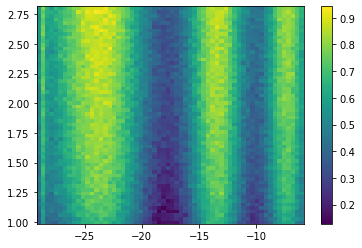

In [32]:
fig, ax = plt.subplots()
c = ax.pcolor(powers, dcs, gain, cmap='viridis')
fig.colorbar(c, ax=ax)

# Gradient Descent

In [85]:
def get_gain(freq_curr, powers_curr, dc_curr):
    anapico.set_freq(1, freq_curr*1e9)
    anapico.set_power(1, powers_curr)
    dc.set_volt(dc_curr)
    time.sleep(10)
    mag, pha = vna.get_data()
    gain = np.mean(mag) - reference_mag_level
    return gain

def wrapped_gain(g): 
    freq_curr = g[0]
    powers_curr = g[1]
    dc_curr = g[2]
    print(g)
    if freq_curr<=freq_pump_max and freq_curr>=freq_pump_min:
        if powers_curr>=power_pump_min and powers_curr<=power_pump_max: 
            if dc_curr<=dc_max and dc_curr>=dc_min:
                gain = get_gain(freq_curr, powers_curr, dc_curr)
                print(gain)
                return -gain
    
    return 100

In [43]:
anapico.set_power(1, -10)
dc.set_volt(2.5)
anapico.set_freq(1, 11.252e9)
vna.set_band(100000)

In [86]:
from scipy import optimize

anapico.on(1)

x0 = np.array([11.296, -6.9, 2.3])
bounds = [(11, 11.5), (-27, -6), (1, 2.8)] 
results = dict()

start_time = datetime.now()
print('Start time', start_time)
# results['shgo'] = optimize.shgo(wrapped_gain, bounds, iters=3, sampling_method='sobol')

# print(results['shgo'])

res = minimize(wrapped_gain, x0, method='nelder-mead', 
               options={'maxiter': 20, 'ftol': 1e-2, 'disp': True})
print(res.x)
    
while res.fun > -18:
    print('_______________________________')
    res = minimize(wrapped_gain, res.x, method='nelder-mead', 
                   options={'maxiter': 20, 'ftol': 1e-2, 'disp': True})
    print(res.x, '--->', res.fun)


end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Start time 2023-12-04 17:45:30.474867
[11.296 -6.9    2.3  ]
-4.971803290241695
[11.8608 -6.9     2.3   ]
[11.296 -7.245  2.3  ]
-6.627750868352173
[11.296 -6.9    2.415]
-8.902499289223691
[10.7312     -7.13        2.37666667]
[11.5784     -6.9575      2.31916667]
[11.296  -7.0725  2.3   ]
-8.656381356367262
[11.296  -6.9     2.3575]
-9.308891518056285
[11.5784 -6.9     2.3   ]
[11.0136     -7.015       2.33833333]
-8.852990502014485
[11.10773333 -7.09166667  2.26805556]
-9.349264243837133
[11.24893333 -6.94791667  2.33513889]
-7.7472830040670075
[11.54702222 -6.93194444  2.28509259]
[11.14695556 -6.99423611  2.32502315]
-6.800262013307375
[11.16525926 -6.82226852  2.34010802]
-8.549891524885822
[11.19794444 -6.88482639  2.33008102]
-8.62187393890558
[11.22147778 -6.94711806  2.31251157]
-7.828024184955709
[11.27246667 -6.92395833  2.31756944]
-7.6966110160622065
[11.296   -6.98625  2.3    ]
-9.014675642947005
[11.23062963 -6.86113426  2.32005401]
-7.942868565701062
[11.24697222 -6.89

KeyboardInterrupt: 

In [65]:
res

 final_simplex: (array([[11.01708642, -7.23506173,  2.32153292],
       [11.0176004 , -7.24147455,  2.31626099],
       [11.01140081, -7.23975562,  2.31765188],
       [11.0113935 , -7.2383581 ,  2.3193509 ]]), array([-13.88120619, -12.37875632,  -7.96265193,  -7.30703752]))
           fun: -13.881206190339384
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 51
           nit: 20
        status: 2
       success: False
             x: array([11.01708642, -7.23506173,  2.32153292])